# Gaussian Processes
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ChemAI-Lab/AI4Chem/blob/main/website/modules/02-gaussian_processes.ipynb) 

**References:**
1. **Chapter 2**:  [Gaussian Processes for Machine LearningOpen Access](https://direct.mit.edu/books/oa-monograph-pdf/2514321/book_9780262256834.pdf), C. E. Rasmussen, C. K. I. Williams
2. **Chapters 6**: [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf), C. M. Bishop.
3. **Chapter 4**: [Machine Learning in Quantum Sciences](https://arxiv.org/pdf/2204.04198)
4. [**The Kernel Cookbook**](https://www.cs.toronto.edu/~duvenaud/cookbook/)

Previously we covered **Kernel methods** and **probabilistic linear models**. 
Gaussian Processes, is the merge of these two classes of models where we describe probabilistically the family of functions through the kernel function. 


We saw that the posterior distribution for a linear model is, 
$$
p(\mathbf{w}|\mathbf{X}, \mathbf{y}) \propto \exp \left (-\frac{1}{2\sigma_n ^2} \left (\mathbf{y} - \mathbf{X}\mathbf{w} \right )^\top  \left (\mathbf{y} - \mathbf{X}\mathbf{w} \right )\right ) \exp \left (-\frac{\alpha}{2}\mathbf{w}^\top\mathbf{w} \right )
$$
$$
p(\mathbf{w}|\mathbf{X}, \mathbf{y}) \sim {\cal N} \left ( \hat{\mathbf{w}} = \frac{1}{\sigma_n^2} \mathbf{A}^{-1}\mathbf{X}^\top\mathbf{y}, \mathbf{A}^{-1} \right ),
$$
where $\mathbf{A} = \sigma_n^2\mathbf{X}^\top \mathbf{X} + \frac{1}{\alpha}I$. <br>
* This are exactly the same equations as in the Ridge regression before we apply the **kernel trick**. 



1. **Prediction Distribution**:
   The predicted outputs for new input data points are assumed to follow a normal distribution, denoted as $ y_* $.
   $$ y_* \sim \ N (\mu(X_*), \sigma(X_*)) $$

2. **Mean Function $\mu(X_*)$**:
   This function represents the expected value of the predictions for the new input points.
   $$ \mu(X_*) = k(X_*, X)^T [K(X, X) + \sigma_n^2I]^{-1}y $$

3. **Covariance Function $\sigma(X_*)$**:
   This function denotes the uncertainty or variance in the predictions for the new input points.
   $$ \sigma(X_*) = k(X_*, X_*) - k(X_*, X)^T [K(X, X) + \sigma_n^2I]^{-1}k(X_*, X) $$

- Here, $k(X_*, X)$ is the kernel function evaluated between the new input points $X_*$ and the training input points $X$, capturing the covariance between them.
- $K(X, X)$ is the kernel matrix evaluated on the training input points, representing the covariance among the training points themselves.
- $\sigma_n^2$ is the variance of the noise in the data, and $I$ is the identity matrix.
- $y$ is the vector of observed target values from the training set.

The GP model thus provides a distribution over possible functions that fit the observed data, and we use this distribution to make predictions with associated uncertainties.


### **Marginal Likelihood**
Contrary to Kernel Ridge regression where, cross-validation is required to fit the kernel, 
The **marginal likelihood** is given by the equation:

$$
\log p(\mathbf{y}|\mathbf{X}) = -\frac{1}{2} \mathbf{y}^T (K + \sigma_n^2 I)^{-1} \mathbf{y} - \frac{1}{2} \log |K + \sigma_n^2 I| - \frac{N}{2} \log(2\pi)
$$

- It represents the probability of generating the observed sample from a prior and is therefore often referred to as **model evidence** or simply evidence.

<br>

We will use the  Mauna Loa Observatory dataset to showcase the power of combining kernels to strength the learning capacity of GPs. [Scikit-learn Tutorial](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html)

## Combination of Kernels

Beyond the list of kernels that I have presented, [**The Kernel Cookbook**](https://www.cs.toronto.edu/~duvenaud/cookbook/), it is possible to construct new **valid** kernels using some base ones, 
1. Sum of kernels: $k_1(\mathbf{x}_i, \mathbf{x}_j) + k_2(\mathbf{x}_i, \mathbf{x}_j) $
2. Product of kernels: $k_1(\mathbf{x}_i, \mathbf{x}_j) * k_2(\mathbf{x}_i, \mathbf{x}_j) $


In [69]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import datetime

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()

co2_data = co2.frame[["year", "month", "day", "co2"]].copy()
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]]
co2_data.head()


,date,co2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


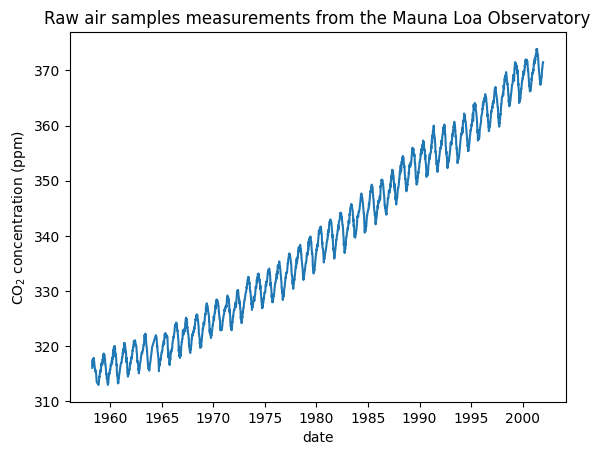

In [70]:
import matplotlib.pyplot as plt

plt.plot(co2_data["date"], co2_data["co2"])
plt.xlabel("date")
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")

In [71]:
# Data
X = (co2_data["date"].dt.year + co2_data["date"].dt.month / 12).to_numpy()
y = co2_data["co2"].to_numpy()
y = y.reshape(-1, 1)
X = X.reshape(-1, 1)
y_mean = np.mean(y)

In [72]:
def plot_gp_predictions(gaussian_process, kernel_name):
    today = datetime.datetime.now()
    current_month = today.year + today.month / 12
    X_test = np.linspace(start=1958, stop=current_month,
                         num=1_000).reshape(-1, 1)
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    mean_y_pred += y_mean

    plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
    plt.plot(X_test, mean_y_pred, color="tab:blue",
             alpha=0.4, label=f"Gaussian process")
    plt.fill_between(
        X_test.ravel(),
        mean_y_pred - std_y_pred,
        mean_y_pred + std_y_pred,
        color="tab:blue",
        alpha=0.2,
    )
    plt.ylim(310, 400)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
    _ = plt.title(
        f"{kernel_name}"
    )

# Linear kernel

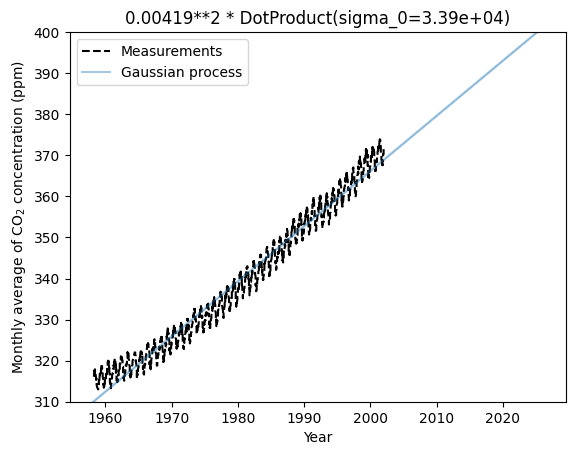

In [73]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel

linear_kernel = ConstantKernel(10.)* \
    DotProduct()

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(
    kernel=linear_kernel,
    normalize_y=False,
    alpha=1e-5,
    n_restarts_optimizer=5,
)
gaussian_process.fit(X, y - y_mean)

plot_gp_predictions(
    gaussian_process, kernel_name=str(gaussian_process.kernel_))

# RBF kernel

/usr/local/anaconda3/envs/ai4chem/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:670: ConvergenceWarning: lbfgs failed to converge after 3 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/anaconda3/envs/ai4chem/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:670: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


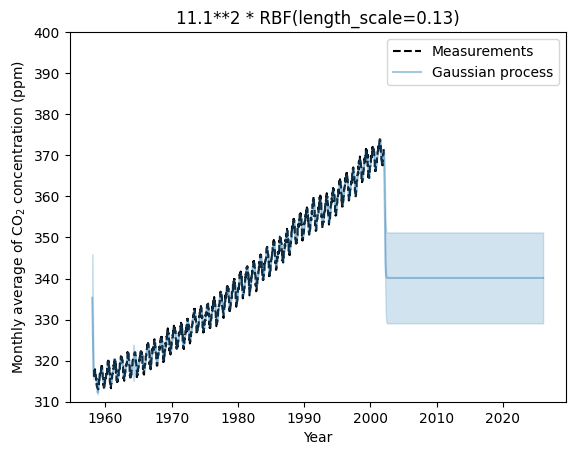

In [79]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

rbf_kernel = ConstantKernel() *   RBF(length_scale=50.0, length_scale_bounds=(1e-1, 1e6))

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(
    kernel=rbf_kernel,
    normalize_y=False,
    alpha=1e-5,
    n_restarts_optimizer=5,
)
gaussian_process.fit(X, y - y_mean)

plot_gp_predictions(
    gaussian_process, kernel_name=str(gaussian_process.kernel_))

# Periodic Kernel

/usr/local/anaconda3/envs/ai4chem/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:670: ConvergenceWarning: lbfgs failed to converge after 8 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/anaconda3/envs/ai4chem/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:670: ConvergenceWarning: lbfgs failed to converge after 21 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/anaconda3/envs/ai4chem/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:670: ConvergenceWarning: lbfgs failed to converge after 18 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.ht

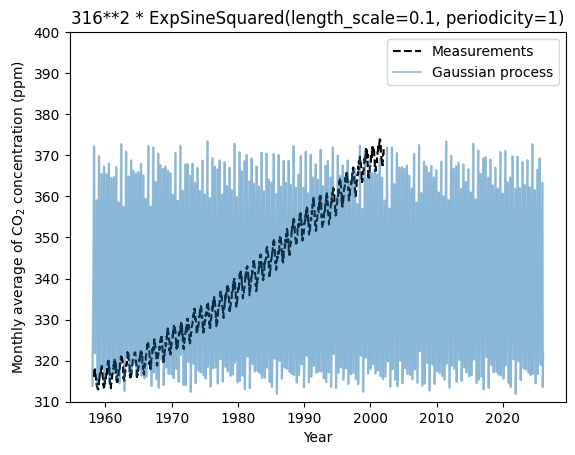

In [80]:
from sklearn.gaussian_process.kernels import ExpSineSquared, ConstantKernel

periodic_kernel = (
    ConstantKernel(100.0)
    * ExpSineSquared(length_scale=1.0,
                     periodicity=3.0,
                     length_scale_bounds=(0.1, 100.0),
                     periodicity_bounds=(1.0, 100.0),)
)

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(
    kernel=periodic_kernel,
    normalize_y=False,
    alpha=1e-4,
    n_restarts_optimizer=5,
)
gaussian_process.fit(X, y - y_mean)

plot_gp_predictions(
    gaussian_process, kernel_name=str(gaussian_process.kernel_))

# RBF + Linear

/usr/local/anaconda3/envs/ai4chem/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


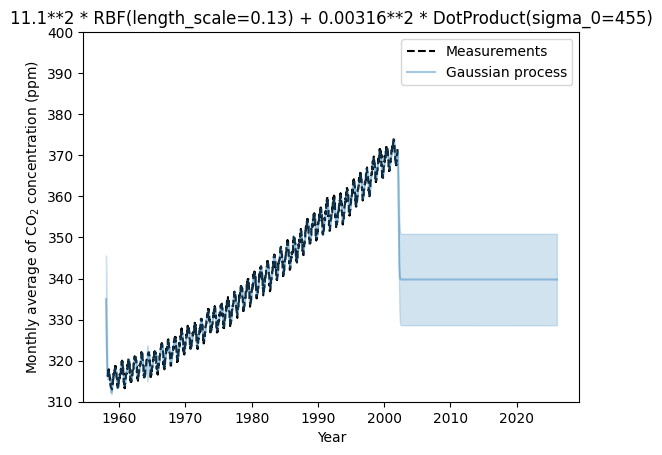

In [81]:
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel

kernel = ConstantKernel(11.0**2) * RBF(length_scale=50.0, length_scale_bounds=(1e-1, 1e6)) + \
    ConstantKernel(11.0**2) * DotProduct()

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=False,
    alpha=1e-3,
    n_restarts_optimizer=5,
)
gaussian_process.fit(X, y - y_mean)

plot_gp_predictions(
    gaussian_process, kernel_name=str(gaussian_process.kernel_))

# Custom kernel example

/usr/local/anaconda3/envs/ai4chem/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/anaconda3/envs/ai4chem/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/anaconda3/envs/ai4chem/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

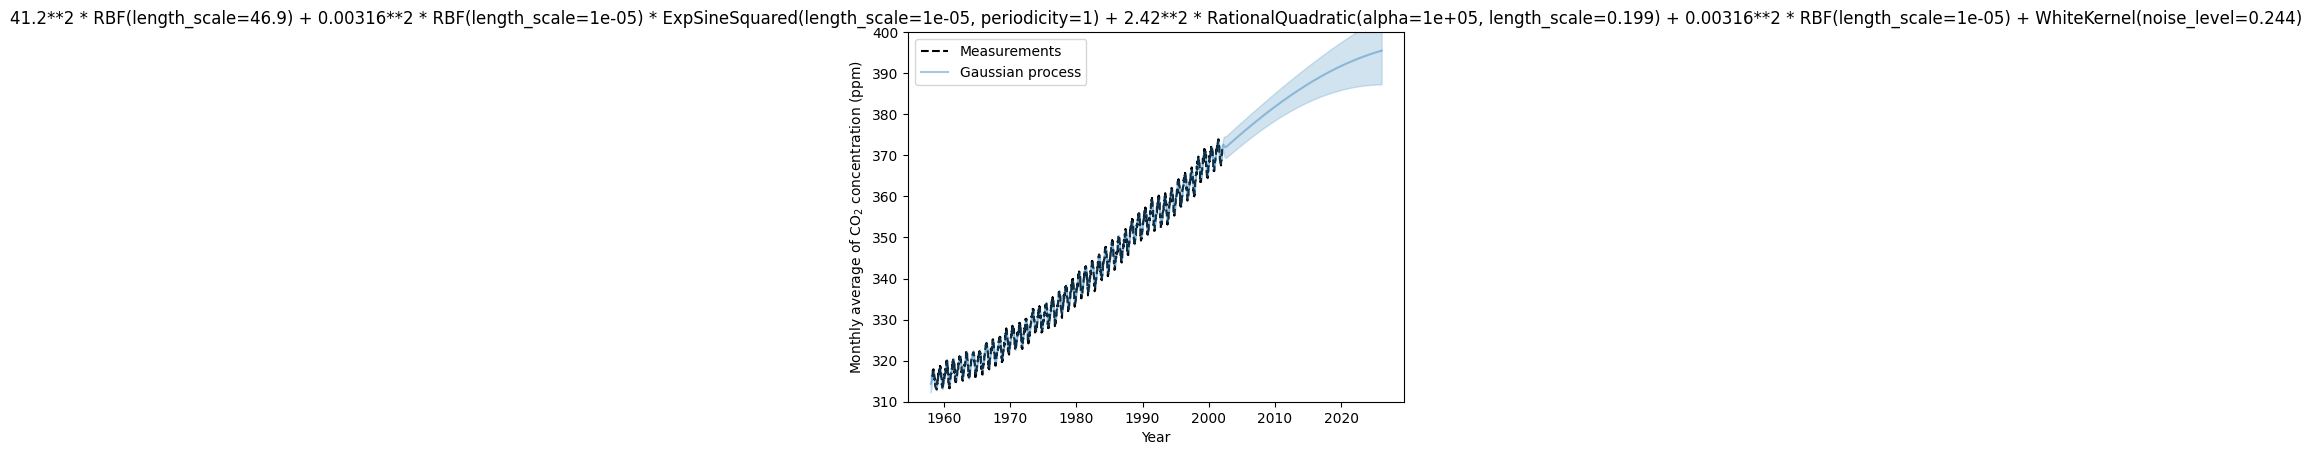

In [82]:
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel
long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(
    kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

plot_gp_predictions(
    gaussian_process, kernel_name=str(gaussian_process.kernel_))